Nous allons d'expérimenter l'implémentation Pytesseract, un modèle OCR développé par Google, pour la détection et la reconnaissance de texte.

In [1]:
# Se débarasser des messages warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# #Importation des biblios nécessaires
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [11]:
!unzip /content/sample_data/CarDetection.zip

Archive:  /content/sample_data/CarDetection.zip
   creating: CarDetection/
   creating: CarDetection/.ipynb_checkpoints/
  inflating: CarDetection/.ipynb_checkpoints/Car_detect-checkpoint.py  
   creating: CarDetection/.vscode/
  inflating: CarDetection/.vscode/settings.json  
  inflating: CarDetection/anpr.py    
  inflating: CarDetection/backend.py  
  inflating: CarDetection/carInWay.mp4  
  inflating: CarDetection/cars_back.png  
  inflating: CarDetection/car_1.jfif  
  inflating: CarDetection/car_back1.png  
  inflating: CarDetection/Car_detect.py  
  inflating: CarDetection/dockerfile  
  inflating: CarDetection/equalityOfData.ipynb  
  inflating: CarDetection/frontend.py  
  inflating: CarDetection/KalmanFilter.py  
  inflating: CarDetection/main.py    
  inflating: CarDetection/ocr.py     
  inflating: CarDetection/Readme.txt  
  inflating: CarDetection/requirements.txt  
  inflating: CarDetection/streamlet.py  
  inflating: CarDetection/yolov8n.pt  
  inflating: CarDetection/y

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# prompt: installer padlle ocr

!pip install paddlepaddle-gpu
!pip install paddleocr



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.0/759.0 MB 839.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 17.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=803dc20c778a1f7363aebc3e23728df304f188ab4b68e33cb0a1957d7c2c51f7
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: albucore
    F

In [24]:
import os
os.chdir('/content/CarDetection')
from Car_detect import car_detect
os.chdir('/content')

/usr/local/lib/python3.11/dist-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


#Détection et extraction de la plaque

In [25]:
#Fonction pour charger un modèle à partir de son chemin d'accès
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [16]:
#Charger le modèle Wpod-Net
from ultralytics import YOLO

# Charger le modèle YOLO entraîné pour la détection de plaques d'immatriculation
wpod_net_path = "/content/CarDetection/yolov8s.pt"
wpod_net = YOLO(wpod_net_path)


In [26]:
#Fonction pour assurer le pré-traitement des images
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

#Fonction pour détecter la plaque et extraire ses coordonnées de l'image
def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

# Utilisation d'implémentation Pytesseract

Une fois la plaque d'immatriculation détectée et extraite, nous allons à présent tenter de reconnaître ses caractères en utilisant Pytesseract.

In [30]:
# Installer pytesseract
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,678 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
# Importer les biblios nécessaires
try:
 from PIL import Image
except ImportError:
 import Image
import cv2
import pytesseract
!which tesseract /usr/bin/tesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

/usr/bin/tesseract
/usr/bin/tesseract


Les prédictions des caractères :  949115) 8°



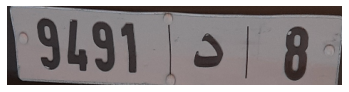

In [ ]:
if (len(LpImg)):

# Prédire les caractères de la plaque
  plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
  plate_image = cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)
  text = pytesseract.image_to_string(plate_image,lang='eng+ara', config='-psm 1')

# Visualiser la plaque ainsi que les prédictions
  print('Les prédictions des caractères : ',text)
  plt.imshow(plate_image)
  plt.axis(False)
  plt.show()

else:
  print('No plat in the image')

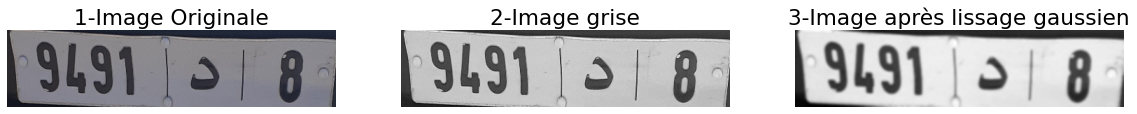

In [ ]:
if (len(LpImg)): #Vérifier si qu'une plaque au moins est bien détectée

    # Convertir le résultat sur un échelle de 8 bits
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    # Convertir l'image en un gradient de couleur grise
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

    # Appliquer un lissage gaussien
    blur = cv2.GaussianBlur(gray,(9,9),0)

# visualiser les résultats des différents étapes
fig = plt.figure(figsize=(20,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=3,nrows=1,figure = fig)
plot_image = [plate_image, gray, blur]
plot_name = ["1-Image Originale","2-Image grise","3-Image après lissage gaussien"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

Ainsi, les prédictions ne sont pas toujours précises malgré l'utilisation des filtres pour éliminer les perturbations.
Entrainenons notre modele sur les lettres arabes donc

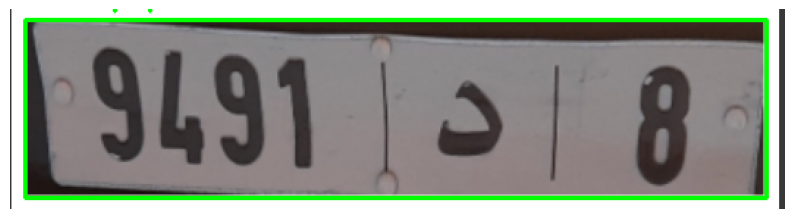


Textes détectés :
1. 9491 | >| 84


In [92]:

def detect_text(image_path):
    # Vérifier si le fichier existe
    if not Path(image_path).exists():
        raise FileNotFoundError(f"L'image {image_path} n'existe pas")

    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Impossible de charger l'image")

    # Prétraitement de l'image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray)

    # Amélioration du contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    # Binarisation adaptative
    binary = cv2.adaptiveThreshold(
        enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Dilatation pour connecter les composants
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Détection des contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Configuration de Tesseract pour détecter l'arabe et l'anglais
    custom_config = r'--oem 3 --psm 6'
    detected_texts = []

    # Traitement de chaque zone de texte
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filtrer les zones trop petites
        if w < 20 or h < 20:
            continue

        # Extraire la région d'intérêt
        roi = enhanced[y:y+h, x:x+w]

        # Détecter le texte avec Tesseract (arabe et anglais)
        text = pytesseract.image_to_string(roi, lang='eng', config=custom_config).strip()

        if text:
            detected_texts.append(text)

            # Dessiner le rectangle sur l'image d'affichage
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Affichage de l'image traitée
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return detected_texts

# Utilisation
test_image_path = '/bin/Aimage_test.png'  # Remplacez par le chemin de votre image

try:
    texts = detect_text(test_image_path)
    print("\nTextes détectés :")

    # Afficher tous les textes détectés
    for i, text in enumerate(texts, 1):
        # Supprimer les lettres latines (A-Z, a-z) tout en gardant les autres caractères
        text = re.sub(r'[a-zA-Z]', '', text)

        # Afficher le texte nettoyé
        print(f"{i}. {text}")

except Exception as e:
    print(f"Erreur : {str(e)}")


In [48]:
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-ara
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-ara
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 645 kB of archives.
After this operation, 1,447 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ara all 1:4.00~git30-7274cfa-1.1 [645 kB]
Fetched 645 kB in 1s (646 kB/s)
Selecting previously unselected package tesseract-ocr-ara.
(Reading database ... 124973 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-ara_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-ara (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-ar

In [90]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re


Suite à plusieurs tests et exécutions, nous avons constaté que notre modèle détecte les lettres d'une certaine manière. Ainsi, afin d'améliorer sa performance et de mieux reconnaître les lettres arabes, nous pouvons appliquer les remplacements suivants dans le texte détecté :

- '>' par 'د'
- ')' par 'و'
- '.' par 'ه'
- '|' par 'ا'
- '--'par 'ب'
            

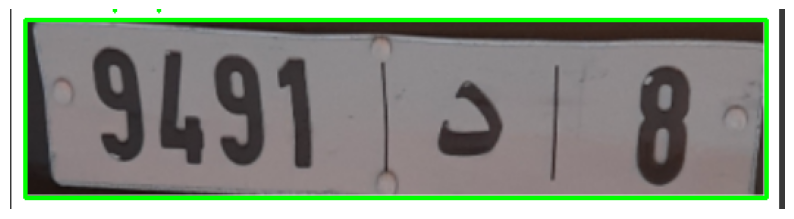


Textes détectés :
1. 9491 | د| 84


In [95]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
def detect_text(image_path):
    # Vérifier si le fichier existe
    if not Path(image_path).exists():
        raise FileNotFoundError(f"L'image {image_path} n'existe pas")

    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Impossible de charger l'image")

    # Prétraitement de l'image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray)

    # Amélioration du contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    # Binarisation adaptative
    binary = cv2.adaptiveThreshold(
        enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Dilatation pour connecter les composants
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Détection des contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Configuration de Tesseract pour détecter l'arabe et l'anglais
    custom_config = r'--oem 3 --psm 6'
    detected_texts = []

    # Traitement de chaque zone de texte
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filtrer les zones trop petites
        if w < 20 or h < 20:
            continue

        # Extraire la région d'intérêt
        roi = enhanced[y:y+h, x:x+w]

        # Détecter le texte avec Tesseract (arabe et anglais)
        text = pytesseract.image_to_string(roi, lang='ara+eng', config=custom_config).strip()

        if text:
            # Remplacer les caractères spécifiques par leurs équivalents arabes
            text = text.replace('>', 'د')  # Remplacer '>' par 'د'
            text = text.replace(')', 'و')  # Remplacer ')' par 'و' (aucune modification ici, mais c'est un exemple)
            text = text.replace('.', 'ه')  # Remplacer '.' par 'ه'
            text = text.replace('ا', 'ا')  # Remplacer '|' par 'ا'
            text = text.replace('--', 'ب')  # Remplacer 'par 'ب'

            detected_texts.append(text)

            # Dessiner le rectangle sur l'image d'affichage
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Affichage de l'image traitée
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return detected_texts

# Utilisation
test_image_path = '/bin/Aimage_test.png'  # Remplacez par le chemin de votre image


try:
    texts = detect_text(test_image_path)
    print("\nTextes détectés :")

    # Afficher tous les textes détectés
    for i, text in enumerate(texts, 1):
        # Nettoyer le texte pour ne garder que les caractères arabes, chiffres et barres "|"
        text = re.sub(r'[^ا-ي0-9|\s]', '', text)  # Garder uniquement l'arabe, les chiffres et les barres

        # Afficher le texte nettoyé
        print(f"{i}. {text}")

except Exception as e:
    print(f"Erreur : {str(e)}")



Nous pouvons constater que pytesseract est capable de détecter les lettres arabes avec précision